# Pentathlon-III: Next Product to Buy Models

* Team-lead GitLab userid: 243
* Group name: Korinna
* Team member names: Siqi Chen, Wen-Hsuan Hung, Xinyu Lou, Yuefeng Mao

## Setup

Please complete this python notebook with your group by answering the questions in `pentathlon-nptb.pdf`. Create a Notebook and HTML file with all your results and comments and push both the Notebook and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML file from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the third group assignment for MGTA 455 and you will be using Git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's change to accept so the team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. You can seen an example of this in action below for the `model1.ipynb` notebook

Some group work-flow tips:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file 
* If you are going to work simultaneously, do it in different notebooks, e.g., 
    - model1.ipynb, model2.ipynb, model3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook
* Put python functions in modules that you can import from your notebooks. See the example below for the `example` function defined in `utils/functions.py`

A graphical depiction of the group work-flow is shown below:

![](images/git-group-workflow-wbg.png)

Tutorial videos about using Git, GitLab, and GitGadget for group assignments:

* Setup the MSBA server to use Git and GitLab: https://youtu.be/zJHwodmjatY
* Dealing with Merge Conflicts: https://youtu.be/qFnyb8_rgTI
* Group assignment practice: https://youtu.be/4Ty_94gIWeA

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import  OneHotEncoder

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, make_scorer,mean_squared_error,r2_score


import matplotlib.pyplot as plt
# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## loading the data - this dataset must NOT be changed
pentathlon_nptb = pd.read_pickle("data/pentathlon_nptb.pkl")
pentathlon_nptb["buyer_yes"] = (pentathlon_nptb["buyer"] == "yes").astype(int)
pentathlon_nptb.head()

,custid,buyer,total_os,message,age,gender,income,education,children,freq_endurance,...,endurance_os,strength_os,water_os,team_os,backcountry_os,winter_os,racquet_os,training,representative,buyer_yes
0,U45198803,no,0.0,endurance,30 to 44,M,25000,14,1.3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0
1,U22197752,no,0.0,backcountry,45 to 59,F,40000,44,0.4,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0
2,U83874832,no,0.0,backcountry,45 to 59,M,50000,24,0.8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,U19423462,no,0.0,winter,45 to 59,F,50000,26,1.1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0
4,U23888305,no,0.0,winter,30 to 44,M,40000,22,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2147483648,1,0


In [3]:
# show dataset description
rsm.describe(pentathlon_nptb)

## Pentathon III: Next Product To Buy 

The available data is based on the last e-mail sent to each Pentathlon customer. Hence, an observation or row in the data is a "customer-promotional e-mail" pair. The data contains the following basic demographic information available to Pentathlon:

* "age": Customer age(coded in 4 buckets:"<30", "30 to 44", "45 to 59", and ">=60") 
* "gender": Gender coded as F or M
* "income": Income in Euros, rounded to the nearest €5,000
* "education": Percentage of college graduates in the customer's neighborhood, coded from 0-100
* "children": Average number of children in the customer's neighborhood

The data also contains basic historical information about customer purchases, specifically, a department-specific frequency measure.

* "freq_endurance-freq_racquet": Number of purchases in each department in the last year, excluding any purchase in response to the last email.

The key outcome variables are:

* "buyer": Did the customer click on the e-mail and complete a purchase within twodays of receiving the e-mail ("yes" or "no")?
* "total_os": Total order size (in Euros) conditional on the customer having purchased (buyer == "yes"). This measures spending across all departments, not just the department that sent the message

While of no importance for the prediction model, we also have data on which departments the customer ordered from when they purchased. This was captured in:

* "endurance_os - racquet_os": Department-specific order size (in Euros). This was a breakdown of the total order size if buyer == "yes". The value was zero for most departments because customers rarely bought products from multiple departments on a single purchase occasion.

Finally, Anna requested that her team divide the data into a training sample and a test sample using a 70 - 30 split. She suggested 70,000 observations in the training sample and 30,000 observations in the test sample. Anna requested the team sample more customers who purchased relative to those that did not purchase. She had learned that some analytical tools did a better job of scoring customers if the response variable had a similar number of "yes" and "no" values.

To achieve a 50/50 split between buyers and non-buyers for the training and test sample, her team randomly picked 50,000 buyers and added 50,000 randomly sampled non-buyers. Given the actual average purchase rate of 1%, buyers in this training sample were oversampled by a factor of 50 (=0.5/0.01). The 100,000 customers were then randomly split into a training sample (70,000 customers) and a test sample (30,000 customers).

In addition to the 100,000 customers used for training and test, Anna asked the team to add a representative sample consisting of another 100,000 customers. This sample was representative in that it was a true random sample of the population and therefore contained the average proportion of buyers, namely 1%. This sample would be used to determine the expected benefits from using a next-product-to-buy model. In summary, the dataset contains 200,000 customers.

1. 70,000 in a training sample (training == 1) 
2. 30,000 in a test sample (training == 0)
3. 100,000 in a representative sample (use is.na(training) or representative == 1)

In [4]:
# run python code from another notebook
%run ./sub-notebooks/model1.ipynb

                    index     OR     OR%   2.5%  97.5% p.values     
1     message[T.strength]  0.977   -2.3%  0.925  1.033    0.415     
2        message[T.water]  0.937   -6.3%  0.887  0.991    0.022    *
3         message[T.team]  0.873  -12.7%  0.826  0.922   < .001  ***
4  message[T.backcountry]  0.859  -14.1%  0.812  0.908   < .001  ***
5       message[T.winter]  0.875  -12.5%  0.828  0.925   < .001  ***
6      message[T.racquet]  0.874  -12.6%  0.826  0.923   < .001  ***


In [5]:
# importing functions from a module/package
from utils import functions
functions.example()


You just accessed a function from your first python packages!
Change the code in utils/function.py to whatever you need for this assignment
Use 'from utils import functions' to get access to your code
You can add modules to import from by adding additional .py files to the 'utils' directory
Note: If you make changes to the content of this file you will have to restart the notebook kernel to get the updates



In [6]:
pd.options.mode.chained_assignment = None

# Part1 Model Selection

In [7]:
pentathlon_nptb["age"] =  pentathlon_nptb.age.astype('category')
pentathlon_nptb["gender"] =  pentathlon_nptb.gender.astype('category')
pentathlon_nptb["message"] =  pentathlon_nptb.message.astype('category')
pentathlon_nptb["buyer_yes"] = rsm.ifelse(pentathlon_nptb.buyer == "yes", 1, rsm.ifelse(pentathlon_nptb.buyer == "no", 0, np.nan))

to_std = pentathlon_nptb.loc[:, "income":"freq_racquet"].columns

# scale numeric variables by (x - mean(x)) / sd(x)
pentathlon_nptb_std = pentathlon_nptb.copy()
pentathlon_nptb_std[to_std] = rsm.scale_df(
    pentathlon_nptb[to_std], sf=1
)

In [8]:
pentathlon_train = pentathlon_nptb_std[pentathlon_nptb_std['training'] == 1]
pentathlon_test = pentathlon_nptb_std[pentathlon_nptb_std['training'] == 0]

## A. logistic regression

In [9]:
lr = smf.glm(
    formula="buyer_yes ~ message + age + gender + income + education + children + \
             freq_racquet + freq_winter + freq_backcountry + freq_team + \
             freq_water + freq_strength + freq_endurance + message:age + message:gender + message:income + message:education + message:children + \
             message:freq_racquet + message:freq_winter + message:freq_backcountry + \
             message:freq_team + message:freq_water + message:freq_strength + message:freq_endurance",
    family=Binomial(link=logit()),
    data=pentathlon_train,
).fit()

In [10]:
pentathlon_test["pred_logit"] = lr.predict(pentathlon_test)

In [11]:
def score_fun(y_pred,y_true):
    AUC = roc_auc_score(y_true,y_pred)
    R2 =r2_score(y_true, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print('AUC ' + str(AUC))
    print('R2 ' + str(R2))
    print('RMSE ' + str(RMSE))
    
    return AUC,R2,RMSE

In [12]:
AUC_Logist, R2_Logist, RMSE_Logist = score_fun(pentathlon_test["pred_logit"],pentathlon_test["buyer_yes"])

AUC 0.8830857777777779
R2 0.450442046599711
RMSE 0.3706608805229819


#### Processing data for other models

In [13]:
### one hot
enc = OneHotEncoder()
enc.fit(pentathlon_nptb_std.loc[:,"message":"gender"])
ans= enc.transform(pentathlon_nptb_std.loc[:,"message":"gender"]).toarray()
ans = pd.DataFrame(ans)
X_num = pentathlon_nptb_std.loc[:,"income":"freq_racquet"]
X_index = pentathlon_nptb_std.loc[:,"training":"representative"]
X = pd.concat([ans,X_num,X_index],axis=1)

In [14]:
X_train = X[X['training']==1]
X_test = X[X['training']==0]
X_repre = X[X['representative']==1]

In [15]:
Y_train = pentathlon_nptb_std[pentathlon_nptb_std['training']==1]["buyer_yes"]
Y_test = pentathlon_nptb_std[pentathlon_nptb_std['training']==0]["buyer_yes"]
Y_repre = pentathlon_nptb_std[pentathlon_nptb_std['representative']==1]["buyer_yes"]

## B. GradientBoosting

In [16]:
gb = GradientBoostingClassifier(learning_rate=0.2, max_depth=4, n_estimators=100).fit(X_train,Y_train)
# Evaluate test set 
pentathlon_test["pred_Boosting"] = gb.predict_proba(X_test)[:,1]
AUC_Boosting, R2_Boosting, RMSE_Boosting = score_fun(pentathlon_test["pred_Boosting"],pentathlon_test["buyer_yes"])

AUC 0.8878090444444444
R2 0.46086591773683605
RMSE 0.3671287520282101


## C. Neural Network

In [17]:
best_model_NN = MLPClassifier(alpha=0.07, hidden_layer_sizes=(8,),learning_rate_init=0.5, max_iter=10000).fit(X_train,Y_train)
# Evaluate test set 
pentathlon_test["pred_NN"] = best_model_NN.predict_proba(X_test)[:,1]
AUC_NN, R2_NN, RMSE_NN = score_fun(pentathlon_test["pred_NN"],pentathlon_test["buyer_yes"])

AUC 0.8751095466666667
R2 0.4217791970075673
RMSE 0.38020415666863533


## D. Random Forest

In [18]:
best_model_RF = RandomForestClassifier(n_estimators = 170, max_depth = 14).fit(X_train, Y_train)
pentathlon_test["pred_RF"] = best_model_RF.predict_proba(X_test)[:,1]

AUC_RF, R2_RF, RMSE_RF = score_fun(pentathlon_test["pred_RF"],pentathlon_test["buyer_yes"])

AUC 0.8867242511111111
R2 0.45830627954282244
RMSE 0.36799922569795496


## E. Decision Tree

In [19]:
best_model = DecisionTreeClassifier(min_samples_leaf=3,min_samples_split=0.01,max_depth=150,max_features=19).fit(X_train,Y_train)
pentathlon_test["pred_DT"] = best_model.predict_proba(X_test)[:,1]

AUC_DT, R2_DT, RMSE_DT = score_fun(pentathlon_test["pred_DT"],pentathlon_test["buyer_yes"])

AUC 0.8749331999999999
R2 0.4295122381828227
RMSE 0.37765320130285446


## Compare Model

In [20]:
score = pd.DataFrame(
    {   "Score": ["AUC", "R2", "RMSE"],
        "Logistic": [AUC_Logist, R2_Logist, RMSE_Logist],
        "Neural Network":[AUC_NN, R2_NN, RMSE_NN],
        "Decision Tree":[AUC_DT, R2_DT, RMSE_DT],
        "Random Forest": [AUC_RF, R2_RF, RMSE_RF],
        "Gradient Boosting": [AUC_Boosting, R2_Boosting, RMSE_Boosting]
    }
)
score

,Score,Logistic,Neural Network,Decision Tree,Random Forest,Gradient Boosting
0,AUC,0.883086,0.875110,0.874933,0.886724,0.887809
1,R2,0.450442,0.421779,0.429512,0.458306,0.460866
2,RMSE,0.370661,0.380204,0.377653,0.367999,0.367129


In [21]:
pentathlon_train["pred_logit"] = lr.predict(pentathlon_train)
pentathlon_train["pred_Boosting"] = gb.predict_proba(X_train)[:,1]
pentathlon_train["pred_NN"] = best_model_NN.predict_proba(X_train)[:,1]
pentathlon_train["pred_RF"] = best_model_RF.predict_proba(X_train)[:,1]
pentathlon_train["pred_DT"] = best_model.predict_proba(X_train)[:,1]

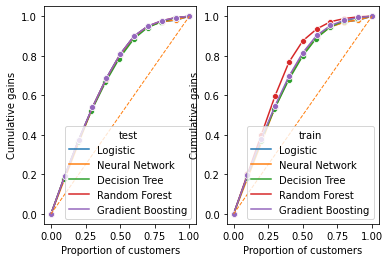

In [22]:
test_plot = pd.DataFrame(
    {   "buyer": pentathlon_test["buyer"],
        "Logistic": pentathlon_test["pred_logit"],
        "Neural Network":pentathlon_test["pred_NN"],
        "Decision Tree":pentathlon_test["pred_DT"],
        "Random Forest": pentathlon_test["pred_RF"],
        "Gradient Boosting": pentathlon_test["pred_Boosting"]
    }
)


train_plot = pd.DataFrame(
    {   "buyer": pentathlon_train["buyer"],
        "Logistic": pentathlon_train["pred_logit"],
        "Neural Network":pentathlon_train["pred_NN"],
        "Decision Tree":pentathlon_train["pred_DT"],
        "Random Forest": pentathlon_train["pred_RF"],
        "Gradient Boosting": pentathlon_train["pred_Boosting"]
    }
)
plt.subplot(1,2,1)
fig1 = rsm.gains_plot(test_plot,"buyer","yes",["Logistic","Neural Network","Decision Tree","Random Forest","Gradient Boosting"])
fig1 = fig1.legend(title='test')

plt.subplot(1,2,2)
fig2 = rsm.gains_plot(train_plot,"buyer","yes",["Logistic","Neural Network","Decision Tree","Random Forest","Gradient Boosting"])
fig2 = fig2.legend(title='train')

#### The five models have similar scores in all three aspects and considering the simplicity of the model, we choose Logistic Regression as our predict model.

# Part2 Answer Questions

### Process data to fit chosen model and then re-estimate model with weights added

In [23]:
pentathlon_nptb["cweight"] = rsm.ifelse(pentathlon_nptb.buyer == "yes", 1, 99)

lr = smf.glm( 
 formula="buyer_yes ~ message + age + gender + income + education + children + \
             freq_racquet + freq_winter + freq_backcountry + freq_team + \
             freq_water + freq_strength + freq_endurance + message:age + message:gender + message:income + message:education + message:children + \
             message:freq_racquet + message:freq_winter + message:freq_backcountry + \
             message:freq_team + message:freq_water + message:freq_strength + message:freq_endurance", 
 family=Binomial(link=logit()), 
 data=pentathlon_nptb_std.query("training == 1"), 
 freq_weights=pentathlon_nptb.query("training == 1")["cweight"], 
).fit(cov_type="HC1") 


In [24]:
pentathlon_repre = pentathlon_nptb_std[pentathlon_nptb_std['representative'] == 1]

In [27]:
pentathlon_repre["p_endurance"] = lr.predict(pentathlon_repre.assign(message="endurance"))
pentathlon_repre["p_strength"] = lr.predict(pentathlon_repre.assign(message="strength"))
pentathlon_repre["p_water"] = lr.predict(pentathlon_repre.assign(message="water"))
pentathlon_repre["p_team"] = lr.predict(pentathlon_repre.assign(message="team"))
pentathlon_repre["p_backcountry"] = lr.predict(pentathlon_repre.assign(message="backcountry"))
pentathlon_repre["p_winter"] = lr.predict(pentathlon_repre.assign(message="winter"))
pentathlon_repre["p_racquet"] = lr.predict(pentathlon_repre.assign(message="racquet"))

### Q1

#### In order to solve this question, we used XGB model to predict different probabilities of purchase with 7 departments message for each customer. Then we compared them and choose the message with highest purchasing probability for the customer as their final message.

In [28]:
pentathlon_repre["to_message"] = (
    pentathlon_repre[["p_endurance", "p_strength", "p_water","p_team","p_backcountry","p_winter","p_racquet"]]
    .idxmax(axis=1)
    .str.replace("p_endurance", "endurance")
    .replace("p_strength", "strength")
    .replace("p_water", "water")
    .replace("p_team", "team")
    .replace("p_backcountry", "backcountry")
    .replace("p_winter", "winter")
    .replace("p_racquet", "racquet")
)

In [29]:
count =pd.crosstab(index=pentathlon_repre.to_message, columns="count")
count

col_0,count
to_message,
backcountry,4354
endurance,40616
racquet,3215
strength,20492
team,10945
water,18550
winter,1828


### Q2

In [30]:
percentage = count['count'].apply(lambda x:(str((round(x/count['count'].sum()*100,3))) + "%"))
percentage

to_message
backcountry     4.354%
endurance      40.616%
racquet         3.215%
strength       20.492%
team           10.945%
water           18.55%
winter          1.828%
Name: count, dtype: object

### Q3

#### Firstly, we regard total_os as an estimation of the revenue if a customer decides to purchase after receiving message. Then we calculate the average total_os of each message type separately and multiply the revenues by 1-COGS as the estimated profit. Finally, we multiply the probability of each message type and its corresponding estimated profit as the expected profit and pick the message type which generates the highest expected profit for each customer as the determined message type.

In [31]:
def non_zero_mean(data):
    sum = np.sum(data)
    count = 0
    for i in range(0,len(data)):
        if data.iloc[i] == 0:
            pass
        else:
            count += 1
    return sum/count

In [32]:
profit_avg  = pd.DataFrame(
    {
    "endurance":[non_zero_mean(pentathlon_train[pentathlon_train['message']=='endurance'].total_os)*(1-0.6)],
    "strength":[non_zero_mean(pentathlon_train[pentathlon_train['message']=='strength'].total_os)*(1-0.6)],
    "water":[non_zero_mean(pentathlon_train[pentathlon_train['message']=='water'].total_os)*(1-0.6)],
    "team":[non_zero_mean(pentathlon_train[pentathlon_train['message']=='team'].total_os)*(1-0.6)],
    "backcountry":[non_zero_mean(pentathlon_train[pentathlon_train['message']=='backcountry'].total_os)*(1-0.6)],
    "winter":[non_zero_mean(pentathlon_train[pentathlon_train['message']=='winter'].total_os)*(1-0.6)],
    "racquet":[non_zero_mean(pentathlon_train[pentathlon_train['message']=='racquet'].total_os)*(1-0.6) ] 
}
)

profit_avg 

,endurance,strength,water,team,backcountry,winter,racquet
0,21.716692,22.358863,22.908576,23.00477,24.271484,23.636012,23.107723


In [33]:
pentathlon_repre["ep_endurance"] = pentathlon_repre.p_endurance * profit_avg['endurance'][0]
pentathlon_repre["ep_strength"] =  pentathlon_repre.p_strength * profit_avg['strength'][0]
pentathlon_repre["ep_water"] =  pentathlon_repre.p_water * profit_avg['water'][0]
pentathlon_repre["ep_team"] =  pentathlon_repre.p_team * profit_avg['team'][0]
pentathlon_repre["ep_backcountry"] =  pentathlon_repre.p_backcountry * profit_avg['backcountry'][0]
pentathlon_repre["ep_winter"] =  pentathlon_repre.p_winter * profit_avg['winter'][0]
pentathlon_repre["ep_racquet"] =  pentathlon_repre.p_racquet * profit_avg['racquet'][0]

In [34]:
pentathlon_repre["to_message_ep"] = (
    pentathlon_repre[["ep_endurance", "ep_strength", "ep_water","ep_team","ep_backcountry","ep_winter","ep_racquet"]]
    .idxmax(axis=1)
    .str.replace("ep_endurance", "endurance")
    .replace("ep_strength", "strength")
    .replace("ep_water", "water")
    .replace("ep_team", "team")
    .replace("ep_backcountry", "backcountry")
    .replace("ep_winter", "winter")
    .replace("ep_racquet", "racquet")
)

In [35]:
pentathlon_repre["ep_target"] = pentathlon_repre[["ep_endurance", "ep_strength", "ep_water","ep_team","ep_backcountry","ep_winter","ep_racquet"]].max(axis=1)

In [36]:
count_ep = pd.crosstab(index=pentathlon_repre.to_message_ep, columns="count")
count_ep

col_0,count
to_message_ep,
backcountry,14415
endurance,23556
racquet,5759
strength,18167
team,12210
water,23136
winter,2757


### Q4

In [37]:
percentage_ep = count_ep['count'].apply(lambda x:(str((round(x/count_ep['count'].sum()*100,3))) + "%"))
percentage_ep

to_message_ep
backcountry    14.415%
endurance      23.556%
racquet         5.759%
strength       18.167%
team            12.21%
water          23.136%
winter          2.757%
Name: count, dtype: object

### Q5

In [38]:
profit_cus = pentathlon_repre.ep_target.agg(np.mean) 
print(f"Expected profit from offer customization: ${profit_cus:,.4f}")

Expected profit from offer customization: $0.3288


### Q6

In [39]:
(
    pentathlon_repre[["ep_endurance", "ep_strength", "ep_water","ep_team","ep_backcountry","ep_winter","ep_racquet"]]
    .agg(np.mean)
    .sort_values(ascending=False)
    .apply(rsm.format_nr, sym="$", dec=2)
)

ep_strength       $0.27
ep_endurance      $0.26
ep_water          $0.24
ep_winter         $0.24
ep_backcountry    $0.23
ep_racquet        $0.22
ep_team           $0.22
dtype: object

### Q7

In [40]:
profit_random = pentathlon_repre[["ep_endurance", "ep_strength", "ep_water","ep_team","ep_backcountry","ep_winter","ep_racquet"]].agg(np.mean).mean()
print(f"Expected profit from offer randomly: ${profit_random:,.4f}")

Expected profit from offer randomly: $0.2405


### Q8

In [41]:
impro_percentage = (profit_cus - profit_random)/profit_random
impro_total = (profit_cus - profit_random) * 5000000
print(f"Improvement from offer customization to offer randomly: {impro_percentage*100:,.2f}%")
print(f"Total profit improvement from offer customization to offer randomly: ${impro_total:,.2f}")

Improvement from offer customization to offer randomly: 36.69%
Total profit improvement from offer customization to offer randomly: $441,250.29


### Comment on the new e-mail policy proposal
There are several weaknesses for the existing policy. First, the emails are allocated on a monthly basis, meaning that the proposal does not take seasonal and holiday effects into consideration. Seasonal effect is important because this influences buyer’s interest and willingness to buy products. For example, in winter, customers might want to buy products from the “winter” category, and in summer, customers would want to buy products from the water category more. Besides, Pentathlon determines the promotional messages for next month based on the data from the current month. This might cause Pentathlon to lose track of trends. For example, it’s hard for the company to predict what people will buy in December using data from November. 
To take seasonal and holiday effects into consideration, Pentathlon can add variables like weather, date into the dataset, so that we can detect seasonality and find out during what condition, which departments have better sales. Also, the company can apply yearly data to analyze the relation between trends and order size. Pentathlon should also reconsider other metrics instead of profit when choosing what message to deliver. For example, trends. When it’s time for the Winter Olympics, Pentathlon can send more emails from the “winter” department. And when it’s time for the Super Bowl, Pentathlon can send more emails from the “team” department. 

The second weakness is that the company determines two messages to send based on the highest expected profit. However, this might lead to the problem that the margin of the product is really high, but the purchase probability is low. In this case, the company might miss the opportunity to promote the product with a high purchase rate. For example, water sports equipment like kayak and sail boats are expensive, which generates higher profit. However, people won’t buy it that often compared with endurance equipment like running shoes and bikes. To solve this, instead of choosing two messages that yield the highest expected profits, Pentathlon can choose one message which generates the highest profit, and another with the highest probability, or choose another message based on the trend.  

Another weakness is the unbalanced resources across departments, since Pentathlon might end up sending out emails from the same department every month, and departments that yield higher profits would be favored continuously. If only 2 departments which yield the highest expected profits could send out messages every month, this will lead to repeat recommendations, meaning that customers keep receiving emails from the same departments (because the department that yields the highest profit might not change often). However, in the dataset, we found that lots of customers bought products from different categories before. Therefore, for customers who have purchased products from 3 or more departments before (these people might be more willing in trying new stuff, or have a broader interest), sending messages from different departments (top 1 to top 4 departments that generate highest profit, rather just the top 2) may be a good choice because customers will  be exposed to more promotional/product information. 
